In [ ]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Download latest version
path = kagglehub.dataset_download("yuriykatser/skoltech-anomaly-benchmark-skab")

print("Path to dataset files:", path)

d:\download\anaconda\envs\timeeval_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\liuyi\.cache\kagglehub\datasets\yuriykatser\skoltech-anomaly-benchmark-skab\versions\1


## Explore the data

### Structure and visulization

In this part, we organize the SKAB dataset by separating it into anomaly-free data and various types of anomalies, and then visualize an anomaly type

In [ ]:

# read all files and categorize them
other_anomaly_mapping = {
    '13.csv': 'Other - Rotor Imbalance (Sharply)',
    '14.csv': 'Other - Rotor Imbalance (Linear)',
    '15.csv': 'Other - Rotor Imbalance (Step)',
    '16.csv': 'Other - Rotor Imbalance (Dirac)',
    '17.csv': 'Other - Rotor Imbalance (Exponential)',
    '18.csv': 'Other - Water Increase (Slow)',
    '19.csv': 'Other - Water Increase (Sudden)',
    '20.csv': 'Other - Cavitation (Draining)',
    '21.csv': 'Other - Cavitation (Two-phase)',
    '22.csv': 'Other - Temperature Increase'
}

data_groups = {
    'Anomaly Free': [],
    'Valve 1': [],
    'Valve 2': []
}
for desc in other_anomaly_mapping.values():
    data_groups[desc] = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            
            if 'anomaly-free' in os.path.basename(root):
                data_groups['Anomaly Free'].append(file_path)
                
            elif 'valve1' in os.path.basename(root):
                data_groups['Valve 1'].append(file_path)
                
            elif 'valve2' in os.path.basename(root):
                data_groups['Valve 2'].append(file_path)
                
            elif 'other' in os.path.basename(root):
                if file in other_anomaly_mapping:
                    category = other_anomaly_mapping[file]
                    data_groups[category].append(file_path)
                else:
                    print(f"Warning: Unknown file in 'other': {file}")

print(f"{'Category':<40} | {'Count'}")
print("-" * 50)
for category, file_list in data_groups.items():
    file_list.sort() 
    print(f"{category:<40} | {len(file_list)}")

# data_groups['Valve 1']

Category                                 | Count
--------------------------------------------------
Anomaly Free                             | 1
Valve 1                                  | 16
Valve 2                                  | 4
Other - Rotor Imbalance (Sharply)        | 1
Other - Rotor Imbalance (Linear)         | 1
Other - Rotor Imbalance (Step)           | 1
Other - Rotor Imbalance (Dirac)          | 1
Other - Rotor Imbalance (Exponential)    | 1
Other - Water Increase (Slow)            | 1
Other - Water Increase (Sudden)          | 1
Other - Cavitation (Draining)            | 1
Other - Cavitation (Two-phase)           | 1
Other - Temperature Increase             | 1


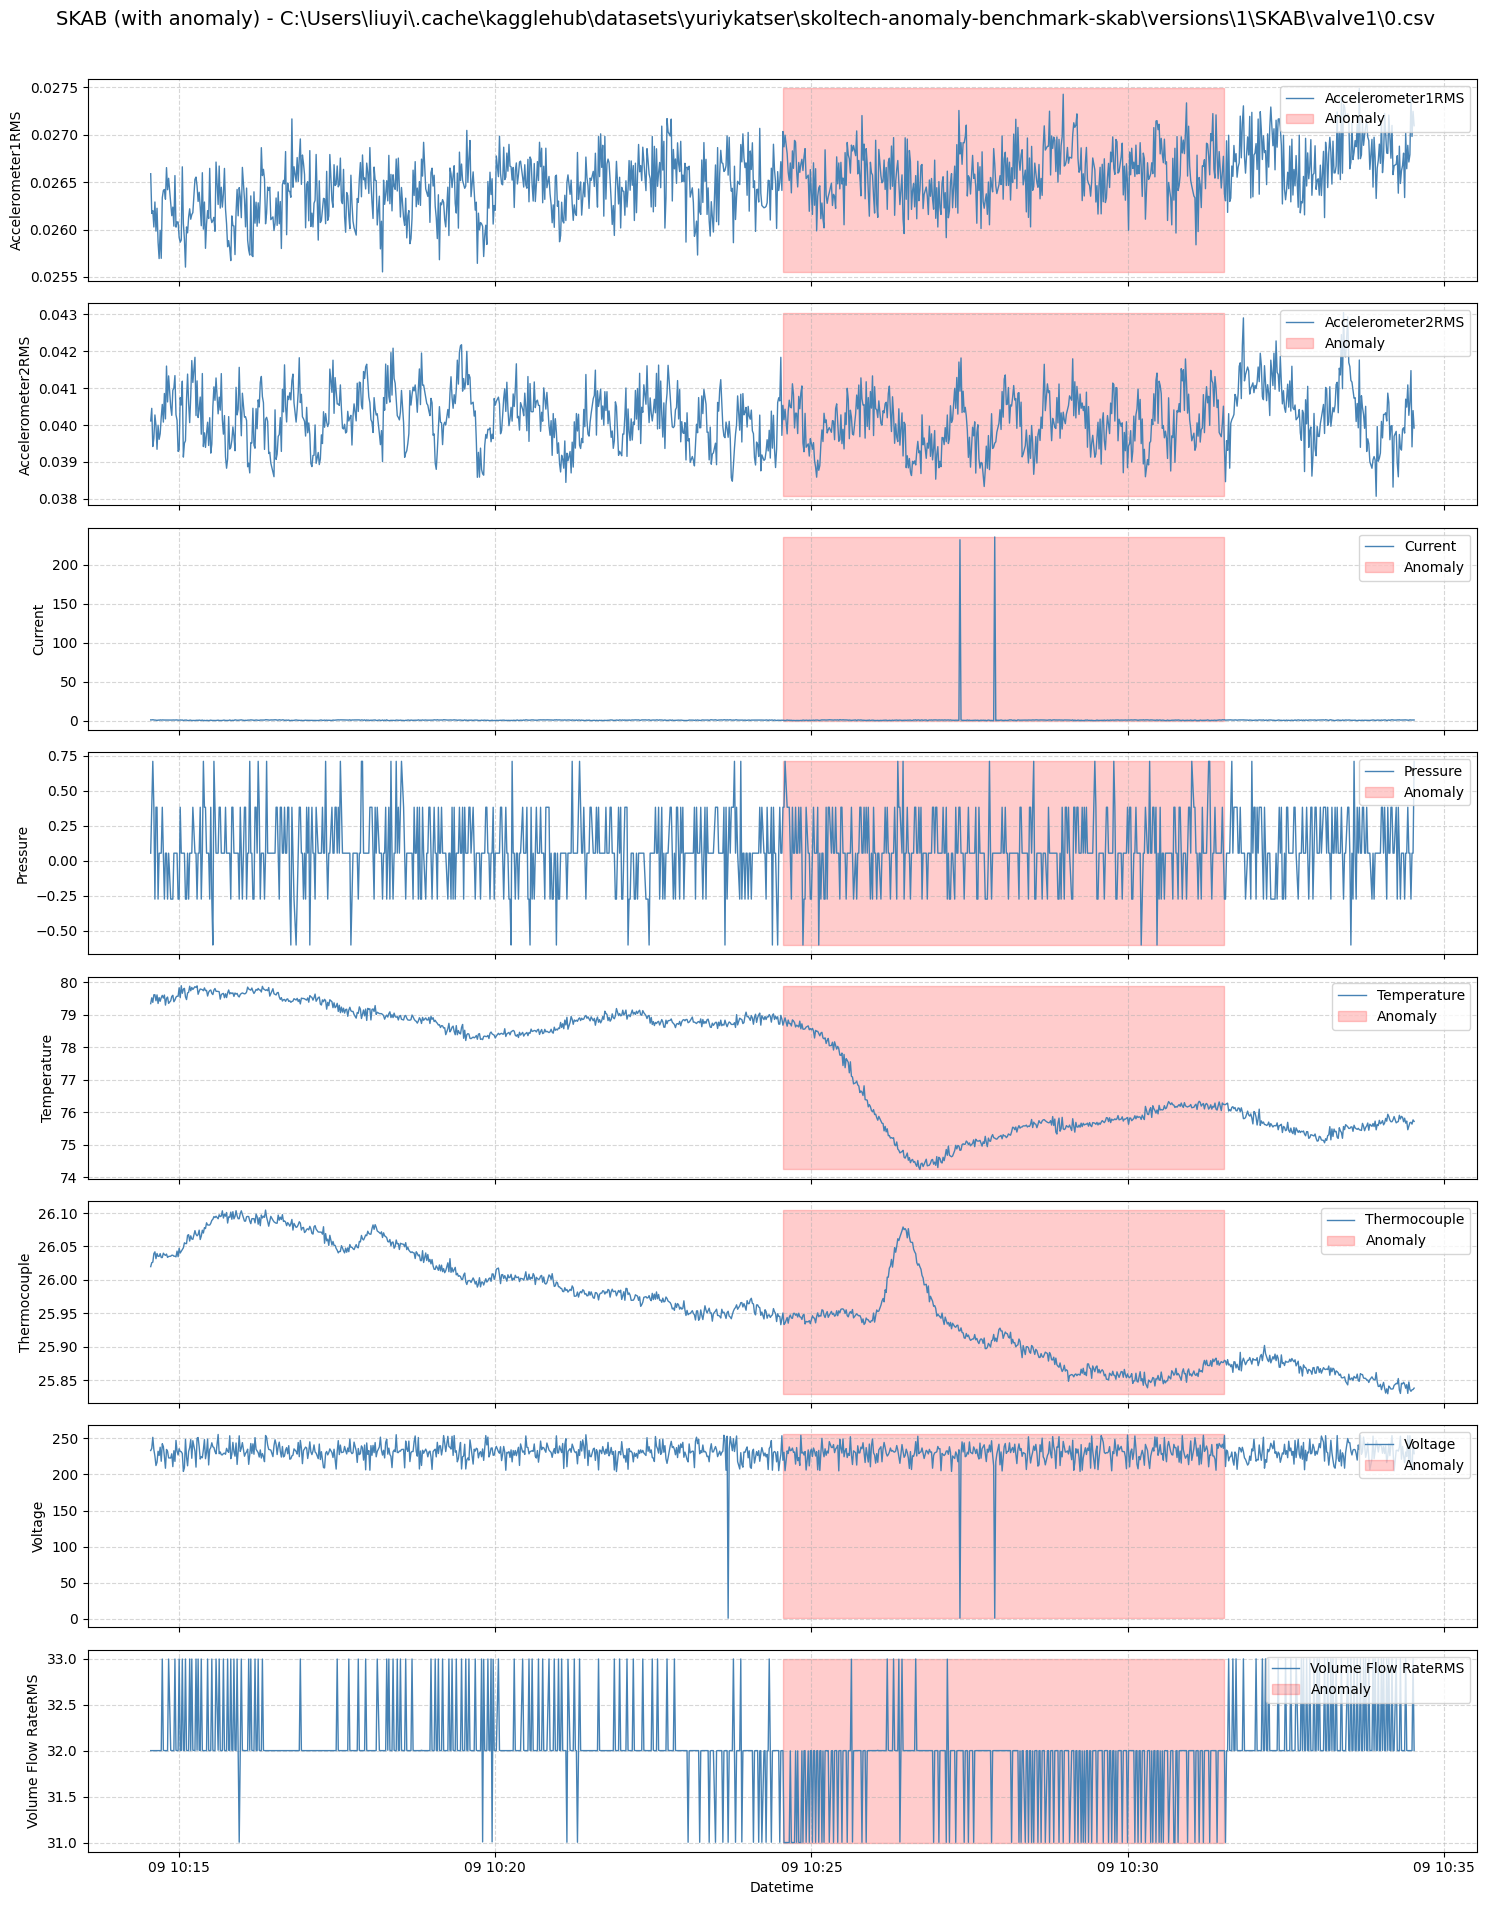

In [ ]:


def visualize_skab_data(data, title="SKAB Sensor Signals"):
    sensor_columns = [col for col in data.columns if col not in ['anomaly', 'changepoint']]

    fig, axes = plt.subplots(nrows=len(sensor_columns), ncols=1, 
                             figsize=(15, 2.5 * len(sensor_columns)), 
                             sharex=True, squeeze=False)

    for i, col in enumerate(sensor_columns):
        ax = axes[i, 0]
        ax.plot(data.index, data[col], label=col, color='steelblue', linewidth=1)

        if 'anomaly' in data.columns:
            ax.fill_between(data.index, data[col].min(), data[col].max(), 
                            where=data['anomaly'] == 1, color='red', alpha=0.2, label='Anomaly')
        
        ax.set_ylabel(col)
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.xlabel('Datetime')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

selected_file =data_groups['Valve 1'][0]

df = pd.read_csv(selected_file, sep=';', index_col='datetime', parse_dates=True)
if 'anomaly' in df.columns:
    df['anomaly'] = df['anomaly'].astype(int)

visualize_skab_data(df, title=f"SKAB (with anomaly) - {selected_file}")

### Feature Analysis

In this section, we extract initial statistics and properties for each feature (dimension). Based on these insights, we provide a preliminary assessment of suitable detection methods for various types of anomalies.

In [ ]:


def extract_features(df_file, target_sensors = ['Accelerometer1RMS','Accelerometer2RMS','Current','Pressure','Temperature','Thermocouple','Voltage','Volume Flow RateRMS']):
    """
    Extract statistical and time-series features from SKAB sensor data.
    Becuse the data is sampled at 1Hz, we focus on time-domain features.
    """
    features = {}
    
    for sensor in target_sensors:
        signal = df_file[sensor].values
        
        n = len(signal)
            
        # Basic Statistics
        features[f'{sensor}_Mean'] = np.mean(signal)
        features[f'{sensor}_Std'] = np.std(signal)  
        features[f'{sensor}_Max'] = np.max(signal)
        features[f'{sensor}_Kurtosis'] = stats.kurtosis(signal, fisher=False)
        
        # Autoregression & Complexity (Time Dependency)
        # Autocorrelation (Lag-1)
        features[f'{sensor}_Autocorr'] = np.corrcoef(signal[:-1], signal[1:])[0, 1]
        
        # Mobility (Hjorth Parameter)
        diff = np.diff(signal)
        std_signal = features[f'{sensor}_Std']
        if std_signal > 1e-9:
            features[f'{sensor}_Mobility'] = np.std(diff) / std_signal
        else:
            features[f'{sensor}_Mobility'] = 0


        # Trend & Stationarity
        x = np.arange(n)
        slope, intercept, r_value, p_value, std_err = linregress(x, signal)
        
        features[f'{sensor}_Slope'] = slope
        features[f'{sensor}_Trend_Strength'] = r_value**2  # 0~1, the closer to 1, the more obvious the linear deterioration
        
        # Stationarity - ADF Test
        # Detect whether the operating condition has sudden changes (Non-stationary).
        try:
            adf_result = adfuller(signal, maxlag=1, autolag=None)
            features[f'{sensor}_Is_Stationary'] = 1 if adf_result[1] < 0.05 else 0
        except:
            features[f'{sensor}_Is_Stationary'] = 0 

    return features


feature_list = []
print("Extracting features from all files...")

for category, file_paths in data_groups.items():
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, sep=';')
            numeric_df = df.select_dtypes(include=[np.number])
            
            if numeric_df.empty: continue

            feats = extract_features(numeric_df)
            feats['Category'] = category
            feature_list.append(feats)
            
        except Exception as e:
            print(f"Error: {e}")

df_features = pd.DataFrame(feature_list)
print("finished.")

df_features.head()

Extracting features from all files...
finished.


,Accelerometer1RMS_Mean,Accelerometer1RMS_Std,Accelerometer1RMS_Max,Accelerometer1RMS_Kurtosis,Accelerometer1RMS_Autocorr,Accelerometer1RMS_Mobility,Accelerometer1RMS_Slope,Accelerometer1RMS_Trend_Strength,Accelerometer1RMS_Is_Stationary,Accelerometer2RMS_Mean,...,Volume Flow RateRMS_Mean,Volume Flow RateRMS_Std,Volume Flow RateRMS_Max,Volume Flow RateRMS_Kurtosis,Volume Flow RateRMS_Autocorr,Volume Flow RateRMS_Mobility,Volume Flow RateRMS_Slope,Volume Flow RateRMS_Trend_Strength,Volume Flow RateRMS_Is_Stationary,Category
0,0.212277,0.004728,0.225967,3.155915,0.929232,0.376118,1.215376e-06,0.486626,1,0.268553,...,125.140908,1.671872,128.3530,2.980300,0.953804,0.303937,0.000485,0.620510,1,Anomaly Free
1,0.026521,0.000329,0.027489,2.749307,0.369018,1.123106,4.871007e-07,0.241384,1,0.040173,...,32.021791,0.458317,32.9986,4.716890,0.000764,1.414288,-0.000157,0.012881,1,Valve 1
2,0.026868,0.000312,0.027946,2.884260,0.029440,1.393617,1.151648e-07,0.014841,1,0.040045,...,31.566819,0.759689,33.0000,2.835052,0.558759,0.939683,-0.001057,0.211556,1,Valve 1
3,0.027755,0.000481,0.028911,2.481912,0.242216,1.231232,2.629722e-07,0.032721,1,0.041471,...,31.523800,1.156789,32.9808,2.508713,0.817646,0.604130,-0.001461,0.174572,1,Valve 1
4,0.027751,0.000399,0.029031,2.931577,0.347151,1.141105,-3.620578e-07,0.089318,1,0.040907,...,30.941518,2.214224,33.0000,2.305695,0.953633,0.304627,-0.002195,0.106617,0,Valve 1


In [ ]:

def remove_useless_sensors(df, threshold=1e-2):
    
    print(f"original feature: {df.shape[1]}")
    
    numeric_df = df.select_dtypes(include=[np.number])
    
    variances = numeric_df.var()
    
    all_columns = numeric_df.columns
    target_sensors = ['Temperature', 'Accelerometer2RMS', 'Volume Flow RateRMS', 'Voltage', 'Thermocouple', 'Current', 'Accelerometer1RMS', 'Pressure']
    
    useless_sensors = []
    
    # 4. 遍历每个传感器，检查其所有统计量的方差
    for sensor in target_sensors:
        sensor_cols = [col for col in all_columns if col.startswith(sensor + '_')]
        
        sensor_variances = variances[sensor_cols]
        
        if (sensor_variances <= threshold).all():
            useless_sensors.append(sensor)
            print(f"found useless sensor (to be removed): {sensor}")


    # 5. 执行移除
    cols_to_drop = []
    for sensor in useless_sensors:
        cols_to_drop.extend([col for col in df.columns if col.startswith(sensor + '_')])
    
    df_cleaned = df.drop(columns=cols_to_drop)
    
    print(f"number of removed sensors: {len(useless_sensors)}")
    print(f"number of removed feature columns: {len(cols_to_drop)}")
    print(f"number of features after filtering: {df_cleaned.shape[1]}")
    
    return df_cleaned, useless_sensors

df_final, dropped_sensors = remove_useless_sensors(df_features, threshold=0.01)

df_final.head()

original feature: 73
number of removed sensors: 0
number of removed feature columns: 0
number of features after filtering: 73


,Accelerometer1RMS_Mean,Accelerometer1RMS_Std,Accelerometer1RMS_Max,Accelerometer1RMS_Kurtosis,Accelerometer1RMS_Autocorr,Accelerometer1RMS_Mobility,Accelerometer1RMS_Slope,Accelerometer1RMS_Trend_Strength,Accelerometer1RMS_Is_Stationary,Accelerometer2RMS_Mean,...,Volume Flow RateRMS_Mean,Volume Flow RateRMS_Std,Volume Flow RateRMS_Max,Volume Flow RateRMS_Kurtosis,Volume Flow RateRMS_Autocorr,Volume Flow RateRMS_Mobility,Volume Flow RateRMS_Slope,Volume Flow RateRMS_Trend_Strength,Volume Flow RateRMS_Is_Stationary,Category
0,0.212277,0.004728,0.225967,3.155915,0.929232,0.376118,1.215376e-06,0.486626,1,0.268553,...,125.140908,1.671872,128.3530,2.980300,0.953804,0.303937,0.000485,0.620510,1,Anomaly Free
1,0.026521,0.000329,0.027489,2.749307,0.369018,1.123106,4.871007e-07,0.241384,1,0.040173,...,32.021791,0.458317,32.9986,4.716890,0.000764,1.414288,-0.000157,0.012881,1,Valve 1
2,0.026868,0.000312,0.027946,2.884260,0.029440,1.393617,1.151648e-07,0.014841,1,0.040045,...,31.566819,0.759689,33.0000,2.835052,0.558759,0.939683,-0.001057,0.211556,1,Valve 1
3,0.027755,0.000481,0.028911,2.481912,0.242216,1.231232,2.629722e-07,0.032721,1,0.041471,...,31.523800,1.156789,32.9808,2.508713,0.817646,0.604130,-0.001461,0.174572,1,Valve 1
4,0.027751,0.000399,0.029031,2.931577,0.347151,1.141105,-3.620578e-07,0.089318,1,0.040907,...,30.941518,2.214224,33.0000,2.305695,0.953633,0.304627,-0.002195,0.106617,0,Valve 1


                     FEATURE IMPORTANCE ANALYSIS                      

Total datasets: 31
Feature dimensions: 72

[1] Top 10 Features (Normal vs Anomaly):
                           feature  importance
                  Current_Kurtosis    0.131429
                  Temperature_Mean    0.116667
             Thermocouple_Autocorr    0.110602
           Pressure_Trend_Strength    0.083333
                   Temperature_Max    0.066667
             Thermocouple_Mobility    0.066667
                Thermocouple_Slope    0.052117
Volume Flow RateRMS_Trend_Strength    0.033333
                  Thermocouple_Std    0.026911
  Accelerometer1RMS_Trend_Strength    0.024909


C:\Users\liuyi\AppData\Local\Temp\ipykernel_30072\444526115.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top15, x='importance', y='feature', palette='viridis')


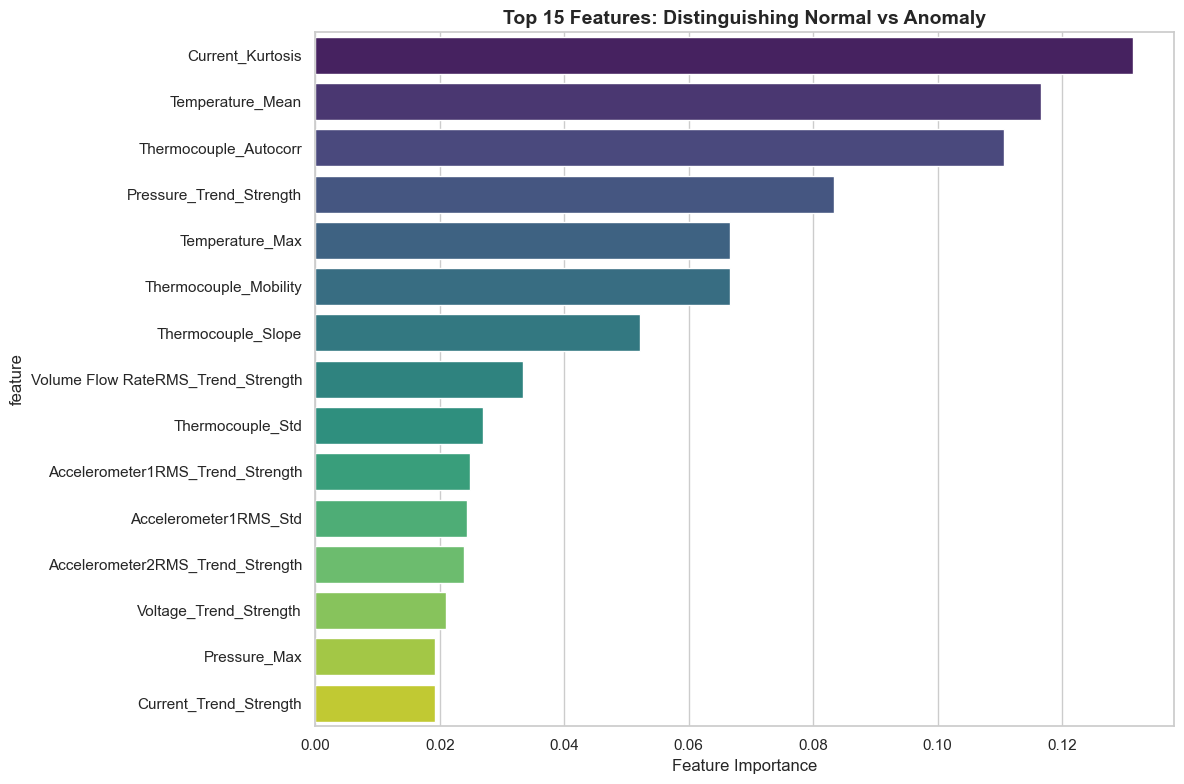


[2] Feature Patterns by Anomaly Category


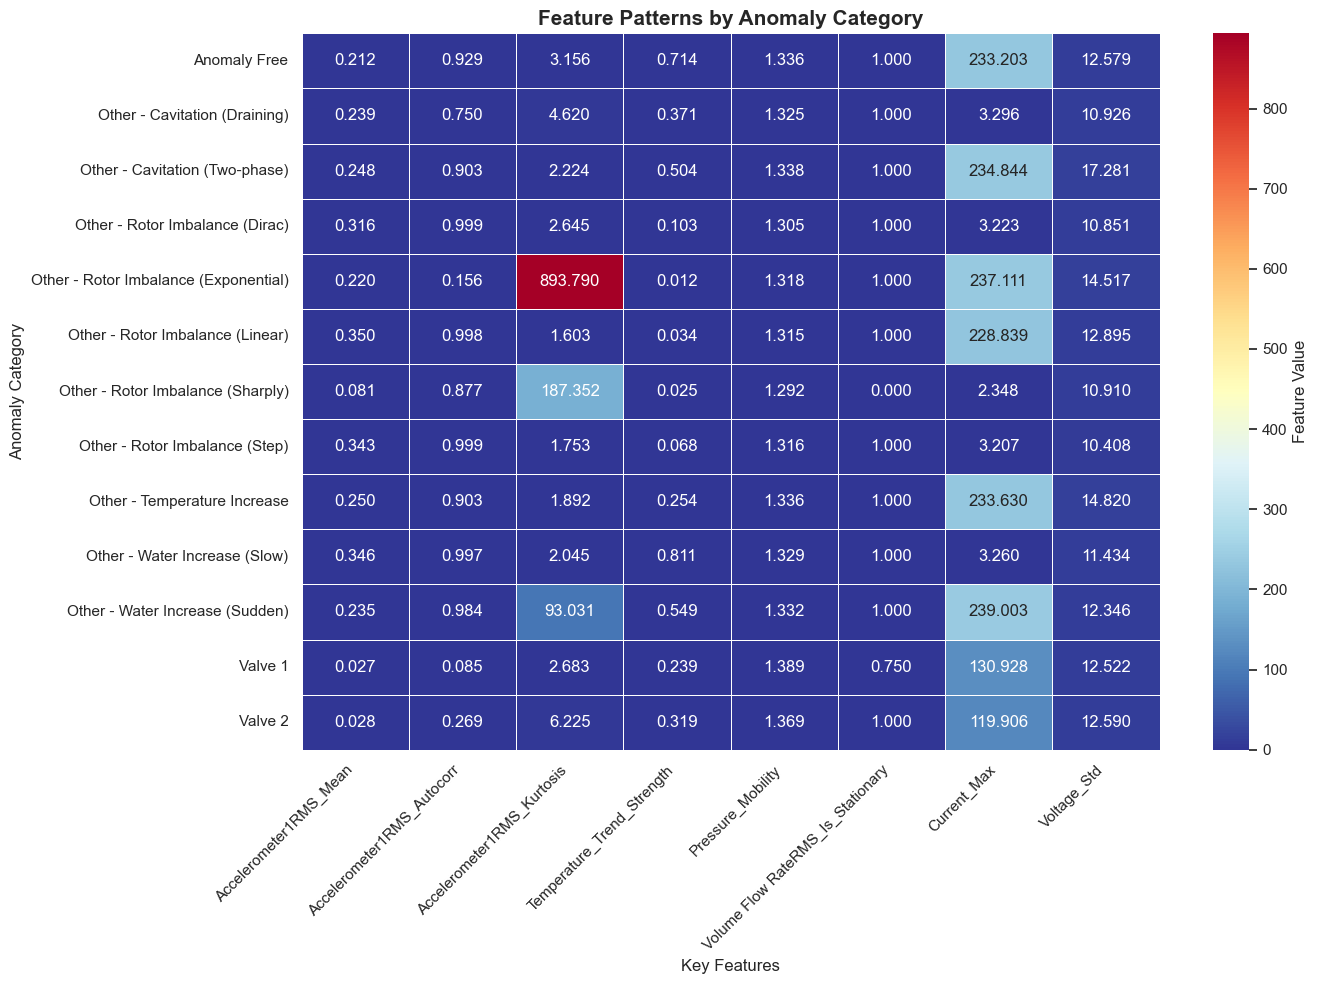


[3] PCA Visualization of Feature Space


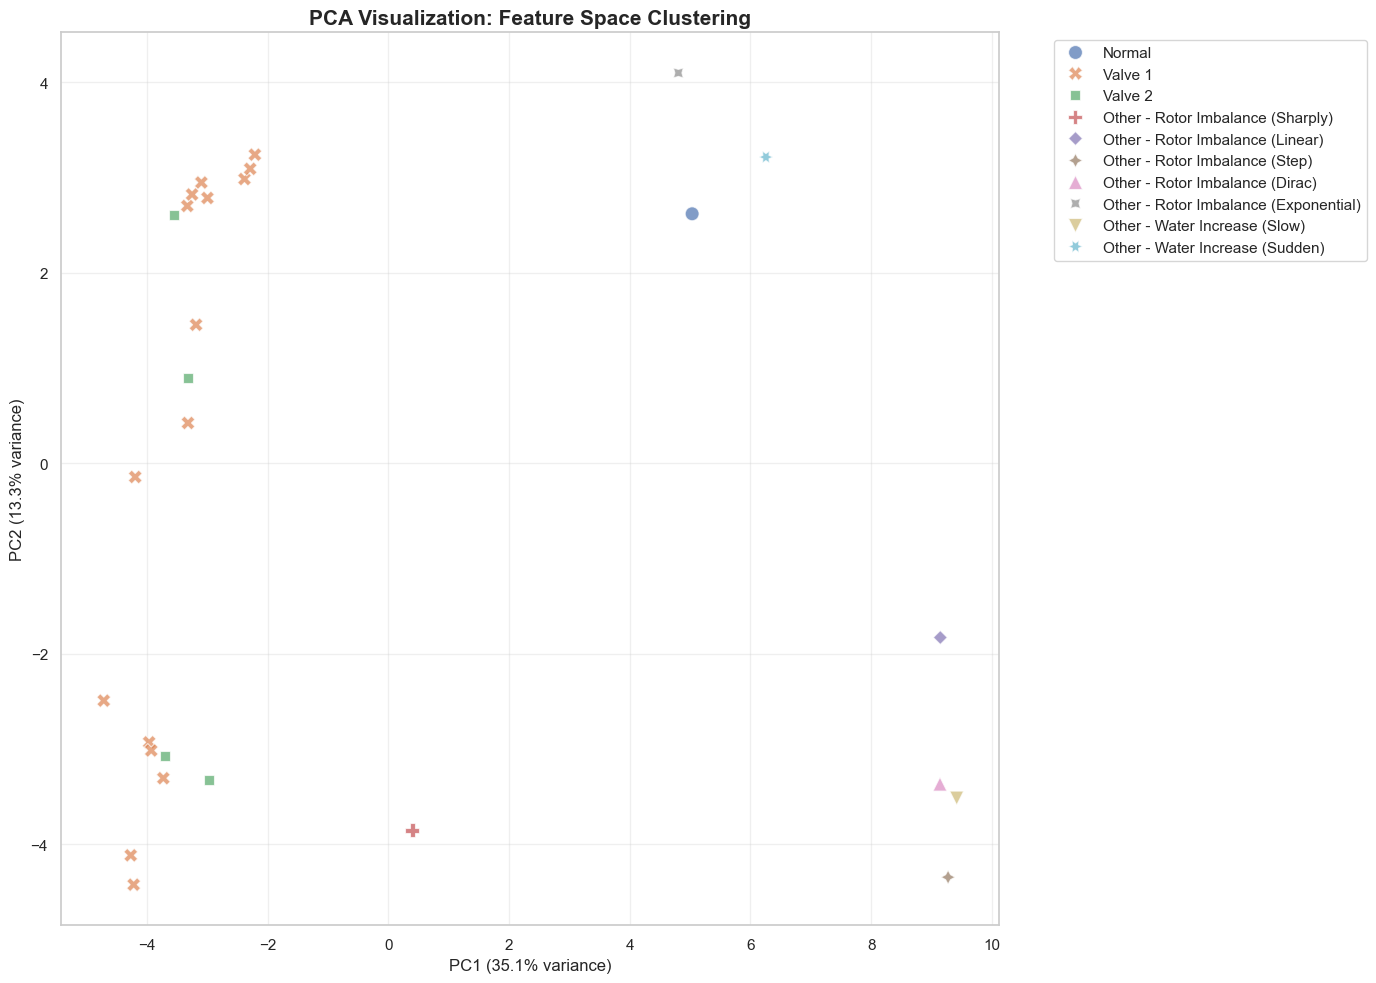

PCA Explained Variance: PC1=35.07%, PC2=13.34%

                  ANALYSIS SUMMARY & RECOMMENDATIONS                  

[1] Top 5 Sensors by Importance:
  1. Thermocouple         ██████████ 0.2644
  2. Temperature          ████████ 0.2224
  3. Current              ██████ 0.1733
  4. Pressure             ████ 0.1141
  5. Volume Flow RateRMS  ██ 0.0672

[2] Top 5 Feature Metrics:
  1. Trend_Strength       0.2305
  2. Kurtosis             0.1719
  3. Mean                 0.1519
  4. Autocorr             0.1263
  5. Max                  0.0946

[3] Data Characteristics & Algorithm Selection:
  • Autocorrelation: 0.471 (MEDIUM) → Mixed approach
  • Trend Strength: 0.170 (WEAK) → Trend is not critical
  • Kurtosis: 75.712 (HIGH) → Use spike-sensitive methods
    ✓ Isolation Forest, Fast-MCD

[4] FINAL RECOMMENDATIONS:
  ⭐ Key Sensor: Thermocouple
  ⭐ Key Metric: Trend_Strength
  → Trend-dominant: OmniAnomaly, MTAD-GAT

Analysis complete! Use these insights to guide algorithm selection.


In [ ]:
# ============================================
# Feature Importance Analysis
# ============================================


# Part 1: Feature Importance for Normal vs Anomaly
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS".center(70))
print("="*70)

df_analysis = df_final.copy()
df_analysis['Is_Anomaly'] = df_analysis['Category'].apply(lambda x: 0 if x == 'Anomaly Free' else 1)

feature_cols = [col for col in df_analysis.columns 
                if col not in ['Category', 'Is_Anomaly'] and df_analysis[col].dtype != 'object']

X = df_analysis[feature_cols]
y = df_analysis['Is_Anomaly']

print(f"\nTotal datasets: {len(df_analysis)}")
print(f"Feature dimensions: {len(feature_cols)}")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n[1] Top 10 Features (Normal vs Anomaly):")
print(importance_df.head(10).to_string(index=False))

# Visualization 1: Top 15 features
plt.figure(figsize=(12, 8))
top15 = importance_df.head(15)
sns.barplot(data=top15, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Features: Distinguishing Normal vs Anomaly', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Part 2: Feature Patterns by Anomaly Category
print("\n[2] Feature Patterns by Anomaly Category")

category_means = df_final.groupby('Category').mean()

key_features = [
    'Accelerometer1RMS_Mean',
    'Accelerometer1RMS_Autocorr',
    'Accelerometer1RMS_Kurtosis',
    'Temperature_Trend_Strength',
    'Pressure_Mobility',
    'Volume Flow RateRMS_Is_Stationary',
    'Current_Max',
    'Voltage_Std'
]

available_features = [f for f in key_features if f in category_means.columns]

plt.figure(figsize=(14, 10))
sns.heatmap(
    category_means[available_features], 
    cmap='RdYlBu_r',
    annot=True, 
    fmt='.3f',
    linewidths=.5,
    cbar_kws={'label': 'Feature Value'}
)
plt.title('Feature Patterns by Anomaly Category', fontsize=15, fontweight='bold')
plt.ylabel('Anomaly Category')
plt.xlabel('Key Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Part 3: PCA Visualization
print("\n[3] PCA Visualization of Feature Space")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Category': df_analysis['Category'].apply(lambda x: 'Normal' if x == 'Anomaly Free' else x)
})

plt.figure(figsize=(14, 10))
top_categories = pca_df['Category'].value_counts().head(10).index.tolist()
plot_pca = pca_df[pca_df['Category'].isin(top_categories)]

sns.scatterplot(
    data=plot_pca,
    x='PC1',
    y='PC2',
    hue='Category',
    style='Category',
    s=100,
    alpha=0.7,
    palette='deep'
)

plt.title('PCA Visualization: Feature Space Clustering', fontsize=15, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA Explained Variance: PC1={pca.explained_variance_ratio_[0]*100:.2f}%, "
      f"PC2={pca.explained_variance_ratio_[1]*100:.2f}%")

# Part 4: Summary & Recommendations
print("\n" + "="*70)
print("ANALYSIS SUMMARY & RECOMMENDATIONS".center(70))
print("="*70)

# Top sensors
sensor_importance = {}
for _, row in importance_df.iterrows():
    sensor = row['feature'].split('_')[0]
    sensor_importance[sensor] = sensor_importance.get(sensor, 0) + row['importance']

sensor_importance = dict(sorted(sensor_importance.items(), key=lambda x: x[1], reverse=True))

print("\n[1] Top 5 Sensors by Importance:")
for i, (sensor, imp) in enumerate(list(sensor_importance.items())[:5], 1):
    bar = '█' * int(imp * 40)
    print(f"  {i}. {sensor:<20} {bar} {imp:.4f}")

# Top feature metrics
metric_importance = {}
for _, row in importance_df.iterrows():
    metric = '_'.join(row['feature'].split('_')[1:])
    metric_importance[metric] = metric_importance.get(metric, 0) + row['importance']

metric_importance = dict(sorted(metric_importance.items(), key=lambda x: x[1], reverse=True))

print("\n[2] Top 5 Feature Metrics:")
for i, (metric, imp) in enumerate(list(metric_importance.items())[:5], 1):
    print(f"  {i}. {metric:<20} {imp:.4f}")

# Data characteristics
print("\n[3] Data Characteristics & Algorithm Selection:")

avg_autocorr = df_final.filter(like='_Autocorr').mean().mean()
print(f"  • Autocorrelation: {avg_autocorr:.3f}", end="")
if avg_autocorr > 0.7:
    print(" (HIGH) → Use PREDICTIVE methods")
    print("    ✓ LSTM-AD: Captures temporal patterns")
    print("    ✓ EncDec-AD: Learns temporal dependencies")
elif avg_autocorr > 0.4:
    print(" (MEDIUM) → Mixed approach")
else:
    print(" (LOW) → Use STATISTICAL methods")
    print("    ✓ Fast-MCD, Isolation Forest")

avg_trend = df_final.filter(like='_Trend_Strength').mean().mean()
print(f"  • Trend Strength: {avg_trend:.3f}", end="")
if avg_trend > 0.3:
    print(" (STRONG) → Use trend-robust methods")
    print("    ✓ OmniAnomaly, MTAD-GAT")
else:
    print(" (WEAK) → Trend is not critical")

avg_kurtosis = df_final.filter(like='_Kurtosis').mean().mean()
print(f"  • Kurtosis: {avg_kurtosis:.3f}", end="")
if avg_kurtosis > 4:
    print(" (HIGH) → Use spike-sensitive methods")
    print("    ✓ Isolation Forest, Fast-MCD")
else:
    print(" (NORMAL)")

# Final recommendations
print("\n[4] FINAL RECOMMENDATIONS:")

top_sensor = list(sensor_importance.keys())[0]
top_metric = list(metric_importance.keys())[0]

print(f"  ⭐ Key Sensor: {top_sensor}")
print(f"  ⭐ Key Metric: {top_metric}")

if 'Autocorr' in top_metric:
    print(f"  → Strong temporal dependency: LSTM-AD, EncDec-AD")
elif 'Trend' in top_metric:
    print(f"  → Trend-dominant: OmniAnomaly, MTAD-GAT")
elif 'Kurtosis' in top_metric or 'Std' in top_metric:
    print(f"  → Spike-based: Isolation Forest, Fast-MCD")

print("\n" + "="*70)
print("Analysis complete! Use these insights to guide algorithm selection.")
print("="*70)


[4] Detailed Statistics by Anomaly Category:

Statistics by Anomaly Category:
                             Category  Datasets  Avg_Autocorr  Avg_Trend  Avg_Kurtosis  Avg_Mobility
        Other - Water Increase (Slow)         1      0.632891   0.422892      2.604274      0.631094
      Other - Water Increase (Sudden)         1      0.606406   0.223937    198.879329      0.679561
                         Anomaly Free         1      0.603846   0.415214    178.878437      0.707178
    Other - Rotor Imbalance (Sharply)         1      0.592930   0.100520     62.483862      0.778929
      Other - Rotor Imbalance (Dirac)         1      0.589335   0.241129      3.130069      0.706770
       Other - Rotor Imbalance (Step)         1      0.579452   0.219532      2.775410      0.732789
         Other - Temperature Increase         1      0.547874   0.174240     81.152058      0.802392
       Other - Cavitation (Two-phase)         1      0.542911   0.338137     61.897028      0.802080
        Othe

C:\Users\liuyi\AppData\Local\Temp\ipykernel_30072\3527620940.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats_df, x='Category', y='Avg_Autocorr', ax=axes[0,0], palette='viridis')
C:\Users\liuyi\AppData\Local\Temp\ipykernel_30072\3527620940.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats_df, x='Category', y='Avg_Trend', ax=axes[0,1], palette='flare')
C:\Users\liuyi\AppData\Local\Temp\ipykernel_30072\3527620940.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats_df, x='Category', y='Avg_Kurtosis', ax=

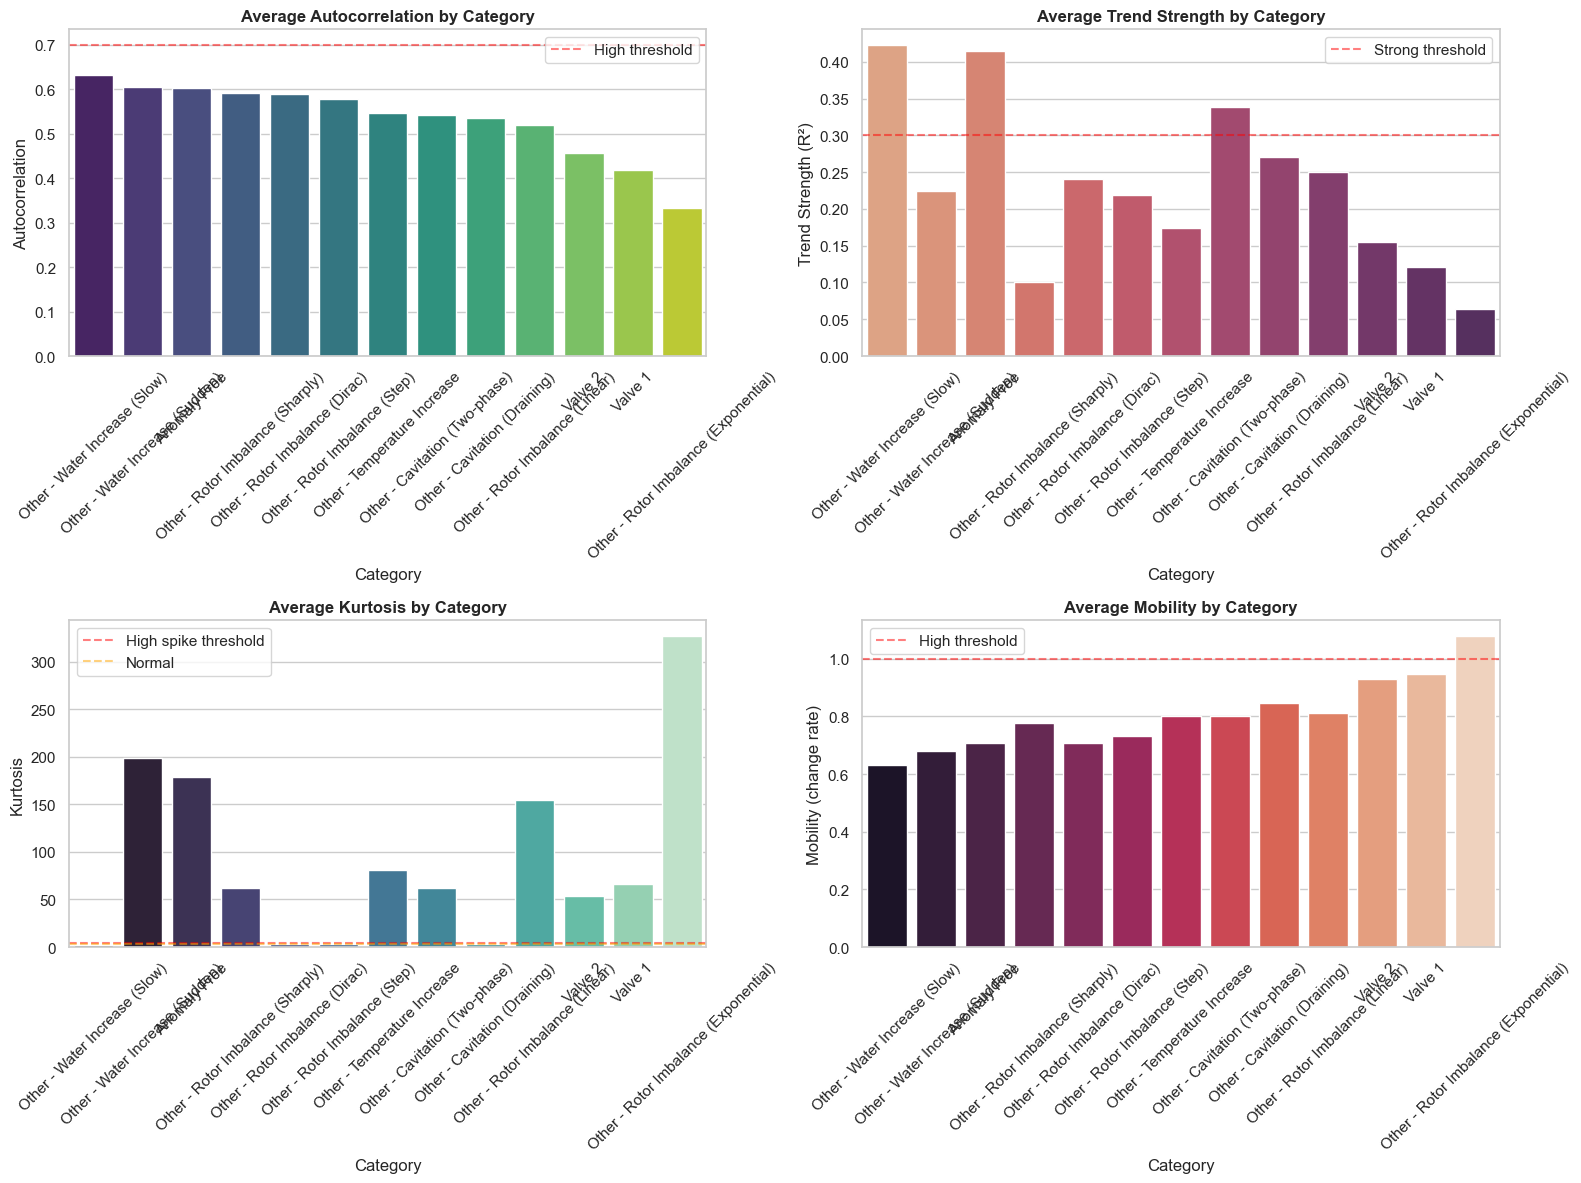


                ALGORITHM RECOMMENDATIONS BY CATEGORY                 

Other - Water Increase (Slow):
  Features: Autocorr=0.633, Trend=0.423, Kurtosis=2.60, Mobility=0.63
  Recommended: LSTM-AD (moderate autocorr), OmniAnomaly (strong trend), OmniAnomaly (flat distribution)

Other - Water Increase (Sudden):
  Features: Autocorr=0.606, Trend=0.224, Kurtosis=198.88, Mobility=0.68
  Recommended: LSTM-AD (moderate autocorr), Fast-MCD (high kurtosis/spikes)

Anomaly Free:
  Features: Autocorr=0.604, Trend=0.415, Kurtosis=178.88, Mobility=0.71
  Recommended: LSTM-AD (moderate autocorr), OmniAnomaly (strong trend), Fast-MCD (high kurtosis/spikes)

Other - Rotor Imbalance (Sharply):
  Features: Autocorr=0.593, Trend=0.101, Kurtosis=62.48, Mobility=0.78
  Recommended: LSTM-AD (moderate autocorr), Fast-MCD (high kurtosis/spikes)

Other - Rotor Imbalance (Dirac):
  Features: Autocorr=0.589, Trend=0.241, Kurtosis=3.13, Mobility=0.71
  Recommended: LSTM-AD (moderate autocorr)

Other - Rotor Imba

In [16]:
# ============================================
# Part 4.5: Detailed Statistics by Category
# ============================================

print("\n[4] Detailed Statistics by Anomaly Category:")
print("="*70)

# Calculate statistics for each category
category_stats = []

for category in df_final['Category'].unique():
    cat_data = df_final[df_final['Category'] == category]
    
    stats_dict = {
        'Category': category,
        'Datasets': len(cat_data),
        'Avg_Autocorr': cat_data.filter(like='_Autocorr').mean().mean(),
        'Avg_Trend': cat_data.filter(like='_Trend_Strength').mean().mean(),
        'Avg_Kurtosis': cat_data.filter(like='_Kurtosis').mean().mean(),
        'Avg_Mobility': cat_data.filter(like='_Mobility').mean().mean(),
    }
    
    category_stats.append(stats_dict)

# Convert to DataFrame and display
stats_df = pd.DataFrame(category_stats)
stats_df = stats_df.sort_values('Avg_Autocorr', ascending=False)

print("\nStatistics by Anomaly Category:")
print(stats_df.to_string(index=False))

# Visualization: Comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Autocorrelation
sns.barplot(data=stats_df, x='Category', y='Avg_Autocorr', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Average Autocorrelation by Category', fontweight='bold')
axes[0,0].set_ylabel('Autocorrelation')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].axhline(0.7, color='red', linestyle='--', alpha=0.5, label='High threshold')
axes[0,0].legend()

# Chart 2: Trend Strength
sns.barplot(data=stats_df, x='Category', y='Avg_Trend', ax=axes[0,1], palette='flare')
axes[0,1].set_title('Average Trend Strength by Category', fontweight='bold')
axes[0,1].set_ylabel('Trend Strength (R²)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(0.3, color='red', linestyle='--', alpha=0.5, label='Strong threshold')
axes[0,1].legend()

# Chart 3: Kurtosis
sns.barplot(data=stats_df, x='Category', y='Avg_Kurtosis', ax=axes[1,0], palette='mako')
axes[1,0].set_title('Average Kurtosis by Category', fontweight='bold')
axes[1,0].set_ylabel('Kurtosis')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].axhline(4.0, color='red', linestyle='--', alpha=0.5, label='High spike threshold')
axes[1,0].axhline(3.0, color='orange', linestyle='--', alpha=0.5, label='Normal')
axes[1,0].legend()

# Chart 4: Mobility
sns.barplot(data=stats_df, x='Category', y='Avg_Mobility', ax=axes[1,1], palette='rocket')
axes[1,1].set_title('Average Mobility by Category', fontweight='bold')
axes[1,1].set_ylabel('Mobility (change rate)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].axhline(1.0, color='red', linestyle='--', alpha=0.5, label='High threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Algorithm recommendations based on each category's features
print("\n" + "="*70)
print("ALGORITHM RECOMMENDATIONS BY CATEGORY".center(70))
print("="*70)

for _, row in stats_df.iterrows():
    category = row['Category']
    autocorr = row['Avg_Autocorr']
    trend = row['Avg_Trend']
    kurtosis = row['Avg_Kurtosis']
    mobility = row['Avg_Mobility']
    
    recommendations = []
    
    # Rule-based algorithm selection
    if autocorr > 0.7:
        recommendations.append("EncDec-AD (high autocorr)")
    elif autocorr > 0.5:
        recommendations.append("LSTM-AD (moderate autocorr)")
    
    if trend > 0.3:
        recommendations.append("OmniAnomaly (strong trend)")
    
    if kurtosis > 4.0:
        recommendations.append("Fast-MCD (high kurtosis/spikes)")
    elif kurtosis < 3.0:
        recommendations.append("OmniAnomaly (flat distribution)")
    
    if mobility > 1.0:
        recommendations.append("LSTM-AD (high mobility)")
    
    # Default if no recommendation
    if not recommendations:
        recommendations = ["EncDec-AD (default)"]
    
    print(f"\n{category}:")
    print(f"  Features: Autocorr={autocorr:.3f}, Trend={trend:.3f}, "
          f"Kurtosis={kurtosis:.2f}, Mobility={mobility:.2f}")
    print(f"  Recommended: {', '.join(recommendations[:3])}")

print("\n" + "="*70)


## Test with 'timeeval'

### Format trasnformation

Canonical format:
```
timestamp,value,is_anomaly
0,12751.0,1
1,8767.0,0
2,7005.0,0
3,5257.0,0
4,4189.0,0
```

Idex file to form:

```
collection_name,dataset_name,train_path,test_path,dataset_type,datetime_index,split_at,train_type,train_is_normal,input_type,length,dimensions,contamination,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
```


In [6]:
# process anomaly-free file to canonical format (train file)

# Note: in this dataset, sep=';'
anomaly_free_df = pd.read_csv(data_groups['Anomaly Free'][0], sep=';', parse_dates=['datetime'])


# 2. Reset index if 'datetime' is the index
if anomaly_free_df.index.name == 'datetime':
    anomaly_free_df.reset_index(inplace=True)

anomaly_free_df.rename(columns={'datetime': 'timestamp'}, inplace=True)
cols = ['timestamp'] + [c for c in anomaly_free_df.columns if c != 'timestamp']
anomaly_free_df = anomaly_free_df[cols]
anomaly_free_df['is_anomaly'] = 0

print("Transformed to conanical format：")
display(anomaly_free_df.head())

Transformed to conanical format：


,timestamp,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,is_anomaly
0,2020-02-08 13:30:47,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664,0
1,2020-02-08 13:30:48,0.204366,0.275727,2.66317,-0.273216,90.2836,26.7760,227.245,122.000,0
2,2020-02-08 13:30:49,0.206103,0.278526,2.63758,0.382638,89.8666,26.7821,237.872,122.000,0
3,2020-02-08 13:30:51,0.204775,0.276948,2.32851,0.382638,90.2192,26.7773,230.422,121.338,0
4,2020-02-08 13:30:52,0.206052,0.278141,2.53422,0.382638,90.1449,26.7773,219.454,121.664,0


In [ ]:

from pathlib import Path

def calculate_anomaly_stats(y_true):
    """计算异常片段的统计信息"""
    changes = np.diff(np.r_[0, y_true, 0])
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]
    lengths = ends - starts
    
    return {
        "num_anomalies": len(lengths),
        "min_anomaly_length": int(np.min(lengths)) if len(lengths) > 0 else 0,
        "median_anomaly_length": int(np.median(lengths)) if len(lengths) > 0 else 0,
        "max_anomaly_length": int(np.max(lengths)) if len(lengths) > 0 else 0,
    }

all_meta_rows = []
base_output_dir = Path("skabdata_v2")

print(f"{'Category':<35} | {'File':<15} | {'Status'}")
print("-" * 70)

for category, file_list in data_groups.items():
    
    if category == 'Anomaly Free':
        continue
        
    for src_path in file_list:
        try:
            df = pd.read_csv(src_path, sep=';', parse_dates=['datetime'])

            if 'changepoint' in df.columns:
                df.drop(columns=['changepoint'], inplace=True)

            df.rename(columns={'datetime': 'timestamp', 'anomaly': 'is_anomaly'}, inplace=True)
            df['is_anomaly'] = df['is_anomaly'].astype(int)

            feature_cols = [c for c in df.columns if c not in ['timestamp', 'is_anomaly']]
            df = df[['timestamp'] + feature_cols + ['is_anomaly']]

            src_path_obj = Path(src_path)
            parent_folder_name = src_path_obj.parent.name 
            file_stem = src_path_obj.stem  # 提取文件名（不含扩展名）
            output_dir = base_output_dir / parent_folder_name
            output_dir.mkdir(parents=True, exist_ok=True)
            
            dataset_unique_name = f"{parent_folder_name}_{file_stem}"
            output_filename = f"{dataset_unique_name}.test.csv"
            output_full_path = output_dir / output_filename
            

            df.to_csv(output_full_path, index=False)

            train_filename = 'skab_anomaly_free.train.csv'
            train_full_path = output_dir / train_filename
            
            if not train_full_path.exists():
                anomaly_free_df.to_csv(train_full_path, index=False)

            length = len(df)
            dimensions = len(feature_cols)
            contamination = df['is_anomaly'].mean()
            anomaly_stats = calculate_anomaly_stats(df['is_anomaly'].values)
            
            data_values = df[feature_cols].values.flatten()
            mean_val = float(np.mean(data_values))
            std_val = float(np.std(data_values))
            
            meta_row = {
                "collection_name": "skab",
                "dataset_name": dataset_unique_name, # 例如 valve1_0
                "train_path": f"{parent_folder_name}/{train_filename}",
                "test_path": f"{parent_folder_name}/{output_filename}",
                "dataset_type": "real",
                "datetime_index": True,
                "split_at": np.nan,
                "train_type": "semi-supervised",
                "train_is_normal": True,
                "input_type": "multivariate" if len(feature_cols) > 1 else "univariate",
                "length": length,
                "dimensions": dimensions,
                "contamination": contamination,
                "num_anomalies": anomaly_stats["num_anomalies"],
                "min_anomaly_length": anomaly_stats["min_anomaly_length"],
                "median_anomaly_length": anomaly_stats["median_anomaly_length"],
                "max_anomaly_length": anomaly_stats["max_anomaly_length"],
                "mean": mean_val,
                "stddev": std_val,
                "trend": "unknown",
                "stationarity": "unknown",
                "period_size": np.nan,
                # [新增] 具体的故障类别描述，非常有价值
                "anomaly_category": category 
            }
            
            all_meta_rows.append(meta_row)
            print(f"{category[:35]:<35} | {file_stem:<15} | Saved")

        except Exception as e:
            print(f"{category[:35]:<35} | {file_stem:<15} | Error: {e}")

index_file = base_output_dir / "datasets.csv"
meta_df = pd.DataFrame(all_meta_rows)

first_cols = ['collection_name', 'dataset_name', 'anomaly_category', 'contamination']
cols = first_cols + [c for c in meta_df.columns if c not in first_cols]
meta_df = meta_df[cols]

meta_df.to_csv(index_file, index=False)

print("\n" + "="*70)
print(f"Processing Complete.")
print(f"Index file saved to: {index_file}")
print(f"Total datasets processed: {len(meta_df)}")

try:
    display(meta_df.head())
except:
    print(meta_df.head())

Category                            | File            | Status
----------------------------------------------------------------------
Valve 1                             | 0               | Saved
Valve 1                             | 1               | Saved
Valve 1                             | 10              | Saved
Valve 1                             | 11              | Saved
Valve 1                             | 12              | Saved
Valve 1                             | 13              | Saved
Valve 1                             | 14              | Saved
Valve 1                             | 15              | Saved
Valve 1                             | 2               | Saved
Valve 1                             | 3               | Saved
Valve 1                             | 4               | Saved
Valve 1                             | 5               | Saved
Valve 1                             | 6               | Saved
Valve 1                             | 7               | Save

,collection_name,dataset_name,anomaly_category,contamination,train_path,test_path,dataset_type,datetime_index,split_at,train_type,...,dimensions,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
0,skab,valve1_0,Valve 1,0.349303,valve1/skab_anomaly_free.train.csv,valve1/valve1_0.test.csv,real,True,NaN,semi-supervised,...,8,1,401,401,401,45.912549,74.358040,unknown,unknown,NaN
1,skab,valve1_1,Valve 1,0.351092,valve1/skab_anomaly_free.train.csv,valve1/valve1_1.test.csv,real,True,NaN,semi-supervised,...,8,1,402,402,402,45.444280,74.366199,unknown,unknown,NaN
2,skab,valve1_10,Valve 1,0.349913,valve1/skab_anomaly_free.train.csv,valve1/valve1_10.test.csv,real,True,NaN,semi-supervised,...,8,1,401,401,401,44.535243,73.862622,unknown,unknown,NaN
3,skab,valve1_11,Valve 1,0.349693,valve1/skab_anomaly_free.train.csv,valve1/valve1_11.test.csv,real,True,NaN,semi-supervised,...,8,1,399,399,399,44.514465,73.980867,unknown,unknown,NaN
4,skab,valve1_12,Valve 1,0.350000,valve1/skab_anomaly_free.train.csv,valve1/valve1_12.test.csv,real,True,NaN,semi-supervised,...,8,1,399,399,399,44.448605,73.824378,unknown,unknown,NaN


In [ ]:

from typing import Dict, Any
from timeeval import TimeEval, DatasetManager, Algorithm, TrainingType, InputDimensionality
from timeeval.adapters import FunctionAdapter
from timeeval.algorithms import (
    lstm_ad,        
    encdec_ad,      
    omnianomaly,    
    fast_mcd,       
    iforest,        
    mtad_gat       
)

from timeeval.params import FixedParameters

# Load dataset metadata
dm = DatasetManager(Path("skabdata_v2"), create_if_missing=False)

# Select datasets and algorithms
datasets = dm.select()
datasets = datasets[-1:]

algorithms = [
    # === A. 经典与统计基线 ===
    
    # 1. Fast-MCD (统计学)
    # 强项: 极快，利用马氏距离检测偏离正态分布的异常
    fast_mcd(params=FixedParameters({
        "support_fraction": 0.9
    })),

    # 2. Isolation Forest (经典 ML)
    # 强项: 工业界标准，不依赖梯度下降，不仅快而且对多维数据非常鲁棒
    iforest(params=FixedParameters({
        "n_trees": 100,      # 树的数量
        "max_samples": 256   # 每棵树的样本采样数
    })),

    # === B. 深度学习 - 预测与重构 ===

    # 3. LSTM-AD (预测类)
    # 强项: 学习时间序列的时序模式，无法预测即为异常
    lstm_ad(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # 4. EncDec-AD (重构类 - 确定性)
    # 强项: LSTM Autoencoder，压缩再解压，异常点无法被准确还原
    encdec_ad(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # 5. OmniAnomaly (重构类 - 概率性)
    # 强项: VAE (变分自编码器)，学习数据的概率分布，捕捉复杂相关性
    omnianomaly(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # === C. 深度学习 - 空间/图关系 ===

    # 6. MTAD-GAT (图注意力网络)
    # 强项: 显式建模变量(传感器)之间的关系图，特别适合物理系统
    mtad_gat(params=FixedParameters({
        "epochs": 10,
        "window_size": 30,
    }))
]

# --- 3. 运行评测 ---
print(f"开始评测 {len(algorithms)} 种代表性算法...")

timeeval = TimeEval(dm, datasets, algorithms, force_training_type_match=False, force_dimensionality_match=False)

# execute evaluation
timeeval.run()
# retrieve results
print(timeeval.get_results())


开始评测 6 种代表性算法...
Running PREPARE phase
Running EVALUATION phase


Evaluating: 100%|██████████| 6/6 [07:57<00:00, 79.52s/it] 

Running FINALIZE phase
FINALIZE phase done.
          Stored results at D:\学习资料\大学\MVA\timeseries\time_seires_projet\results\2026_01_03_23_06_30\results.csv.
          Overall runtime of this TimeEval run: 652.2874794006348 seconds
        
                                                ROC_AUC_mean  \
algorithm                  collection dataset                  
EncDec-AD                  skab       valve2_3      0.816291   
Fast-MCD                   skab       valve2_3      0.764658   
Isolation Forest (iForest) skab       valve2_3      0.557207   
LSTM-AD                    skab       valve2_3      0.704392   
MTAD-GAT                   skab       valve2_3      0.550814   
OmniAnomaly                skab       valve2_3      0.848979   

                                                train_main_time_mean  \
algorithm                  collection dataset                          
EncDec-AD                  skab       valve2_3             45.478745   
Fast-MCD                   ska

C:\Users\liuyi\AppData\Local\Temp\ipykernel_30072\2864108566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='algorithm', y='ROC_AUC_mean', data=sorted_df, ax=axes[0], palette='viridis')


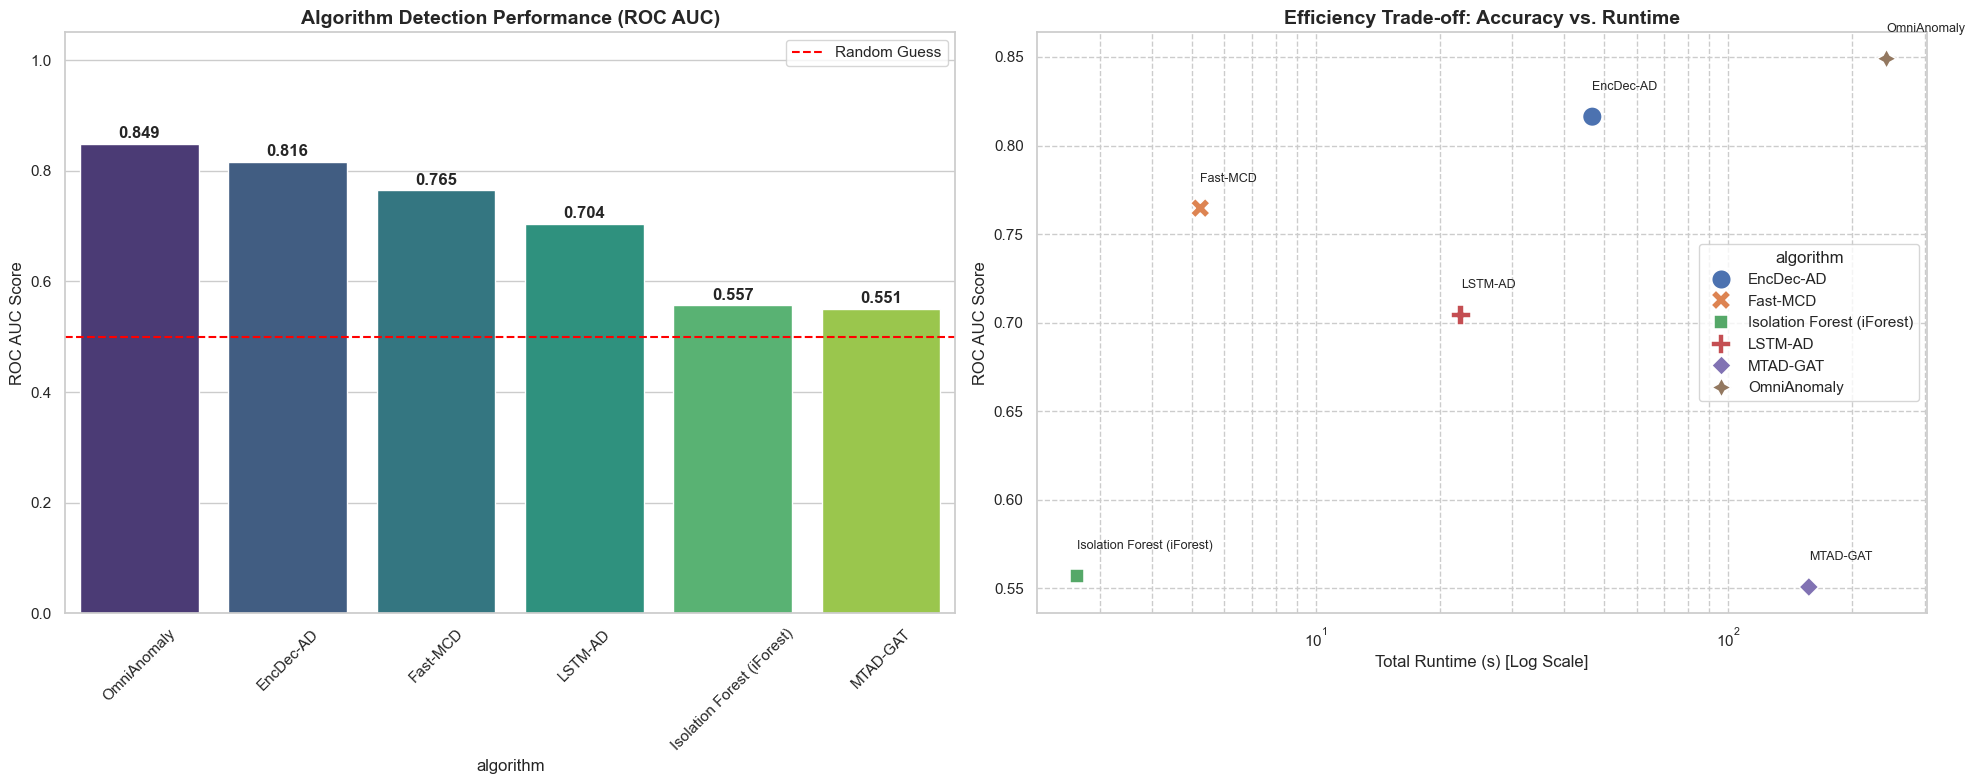

In [ ]:



df = timeeval.get_results().reset_index()

target_cols = ['algorithm', 'ROC_AUC_mean', 'train_main_time_mean', 'execute_main_time_mean']
available_cols = [c for c in target_cols if c in df.columns]
plot_df = df[available_cols].copy()

if 'train_main_time_mean' in plot_df.columns:
    plot_df['train_main_time_mean'] = plot_df['train_main_time_mean'].fillna(0)
if 'execute_main_time_mean' in plot_df.columns:
    plot_df['execute_main_time_mean'] = plot_df['execute_main_time_mean'].fillna(0)

plot_df['total_time'] = plot_df['train_main_time_mean'] + plot_df['execute_main_time_mean']

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- 图表 1: 准确率排行榜 (ROC_AUC) ---
sorted_df = plot_df.sort_values(by='ROC_AUC_mean', ascending=False)

sns.barplot(x='algorithm', y='ROC_AUC_mean', data=sorted_df, ax=axes[0], palette='viridis')
axes[0].set_title('Algorithm Detection Performance (ROC AUC)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('ROC AUC Score')
axes[0].set_ylim(0, 1.05)
axes[0].axhline(0.5, color='red', linestyle='--', label='Random Guess')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45) 

for i, v in enumerate(sorted_df['ROC_AUC_mean']):
    axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')

# --- 图表 2: 性价比分析 ---
sns.scatterplot(data=plot_df, x='total_time', y='ROC_AUC_mean', 
                hue='algorithm', style='algorithm', s=200, ax=axes[1], palette='deep')

axes[1].set_title('Efficiency Trade-off: Accuracy vs. Runtime', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Runtime (s) [Log Scale]')
axes[1].set_ylabel('ROC AUC Score')
axes[1].set_xscale('log') 
axes[1].grid(True, which="both", ls="--")

# 添加标签
for i in range(plot_df.shape[0]):
    row = plot_df.iloc[i]
    # 稍微错开标签位置
    axes[1].text(row['total_time'], row['ROC_AUC_mean']+0.015, 
                 row['algorithm'], fontsize=9, ha='left')

plt.tight_layout()
plt.show()

In [ ]:


# Load dataset metadata
dm = DatasetManager(Path("skabdata_v2"), create_if_missing=False)

# Select datasets and algorithms
datasets = dm.select()

algorithms = [
    # === A. 经典与统计基线 ===
    
    # 1. Fast-MCD (统计学)
    # 强项: 极快，利用马氏距离检测偏离正态分布的异常
    fast_mcd(params=FixedParameters({
        "support_fraction": 0.9
    })),

    # 2. Isolation Forest (经典 ML)
    # 强项: 工业界标准，不依赖梯度下降，不仅快而且对多维数据非常鲁棒
    iforest(params=FixedParameters({
        "n_trees": 100,      # 树的数量
        "max_samples": 256   # 每棵树的样本采样数
    })),

    # === B. 深度学习 - 预测与重构 ===

    # 3. LSTM-AD (预测类)
    # 强项: 学习时间序列的时序模式，无法预测即为异常
    lstm_ad(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # 4. EncDec-AD (重构类 - 确定性)
    # 强项: LSTM Autoencoder，压缩再解压，异常点无法被准确还原
    encdec_ad(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # 5. OmniAnomaly (重构类 - 概率性)
    # 强项: VAE (变分自编码器)，学习数据的概率分布，捕捉复杂相关性
    omnianomaly(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # === C. 深度学习 - 空间/图关系 ===

    # 6. MTAD-GAT (图注意力网络)
    # 强项: 显式建模变量(传感器)之间的关系图，特别适合物理系统
    mtad_gat(params=FixedParameters({
        "epochs": 10,
        "window_size": 30,
    }))
]

# --- 3. 运行评测 ---
print(f"开始评测 {len(algorithms)} 种代表性算法...")

timeeval = TimeEval(dm, datasets, algorithms, force_training_type_match=False, force_dimensionality_match=False)

# execute evaluation
timeeval.run()
# retrieve results
print(timeeval.get_results())

开始评测 6 种代表性算法...
Running PREPARE phase
Running EVALUATION phase


Evaluating: 100%|██████████| 180/180 [13:30:33<00:00, 270.18s/it]      

Running FINALIZE phase
FINALIZE phase done.
          Stored results at D:\学习资料\大学\MVA\timeseries\time_seires_projet\results\2026_01_03_23_24_59\results.csv.
          Overall runtime of this TimeEval run: 48640.98473739624 seconds
        
                                 ROC_AUC_mean  train_main_time_mean  \
algorithm   collection dataset                                        
EncDec-AD   skab       other_13      0.000551             44.501379   
                       other_14      0.758927             44.201203   
                       other_15      0.481995             42.010213   
                       other_16      0.405105             43.601726   
                       other_17      0.941304             45.601366   
...                                       ...                   ...   
OmniAnomaly skab       valve1_9      0.744265            216.200214   
                       valve2_0      0.741905            215.827003   
                       valve2_1      0.842593    

Results columns: ['algorithm', 'collection', 'dataset', 'ROC_AUC_mean', 'train_main_time_mean', 'execute_main_time_mean', 'repetitions']

Metadata columns: ['collection_name', 'dataset_name', 'anomaly_category', 'contamination', 'train_path', 'test_path', 'dataset_type', 'datetime_index', 'split_at', 'train_type', 'train_is_normal', 'input_type', 'length', 'dimensions', 'num_anomalies', 'min_anomaly_length', 'median_anomaly_length', 'max_anomaly_length', 'mean', 'stddev', 'trend', 'stationarity', 'period_size']

                 BEST ALGORITHM PER ANOMALY CATEGORY                  
                     anomaly_category   algorithm  ROC_AUC_mean
Other - Rotor Imbalance (Exponential)   EncDec-AD      0.941304
    Other - Rotor Imbalance (Sharply)    Fast-MCD      0.924663
                              Valve 1    Fast-MCD      0.876297
        Other - Cavitation (Draining) OmniAnomaly      0.852942
      Other - Water Increase (Sudden)   EncDec-AD      0.838029
                           

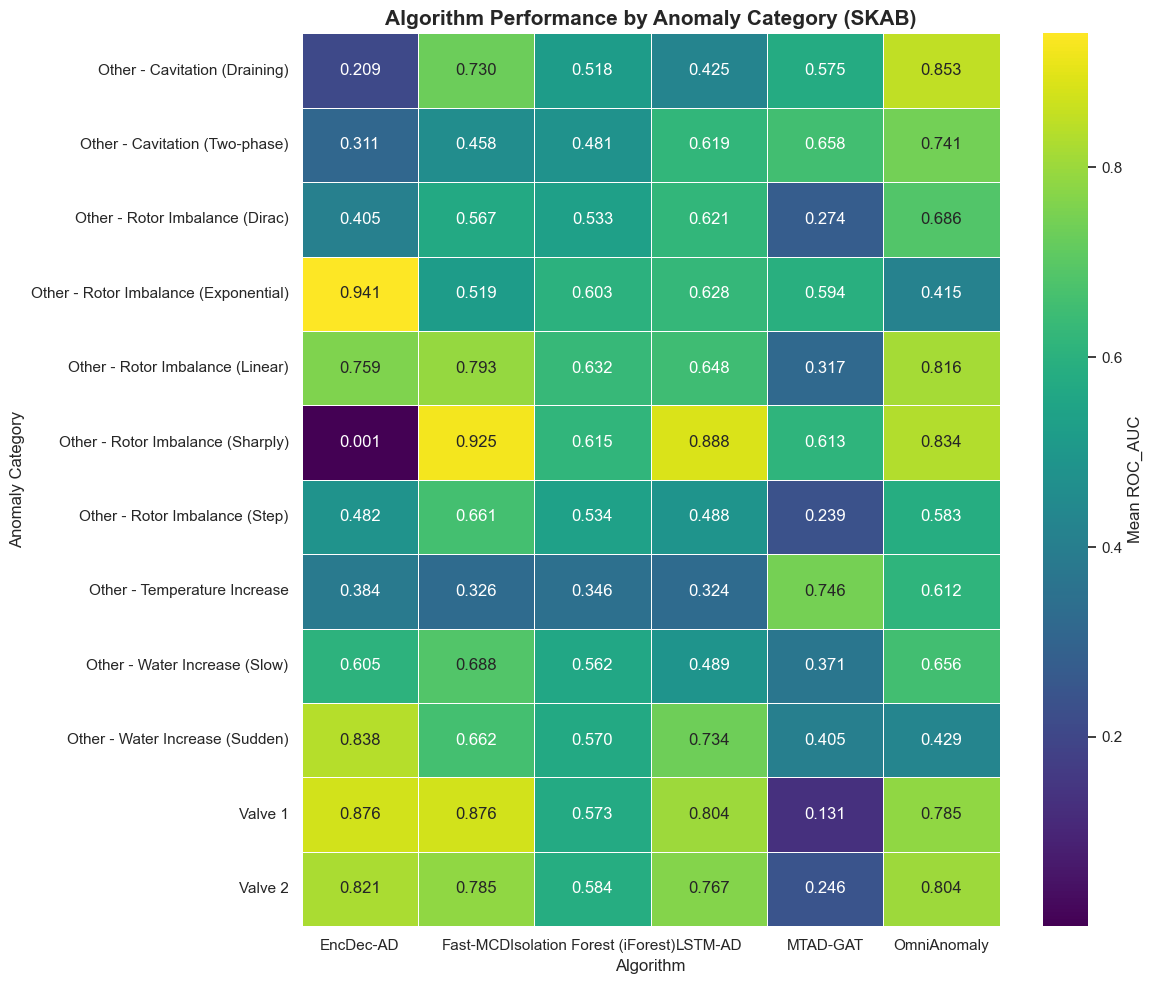

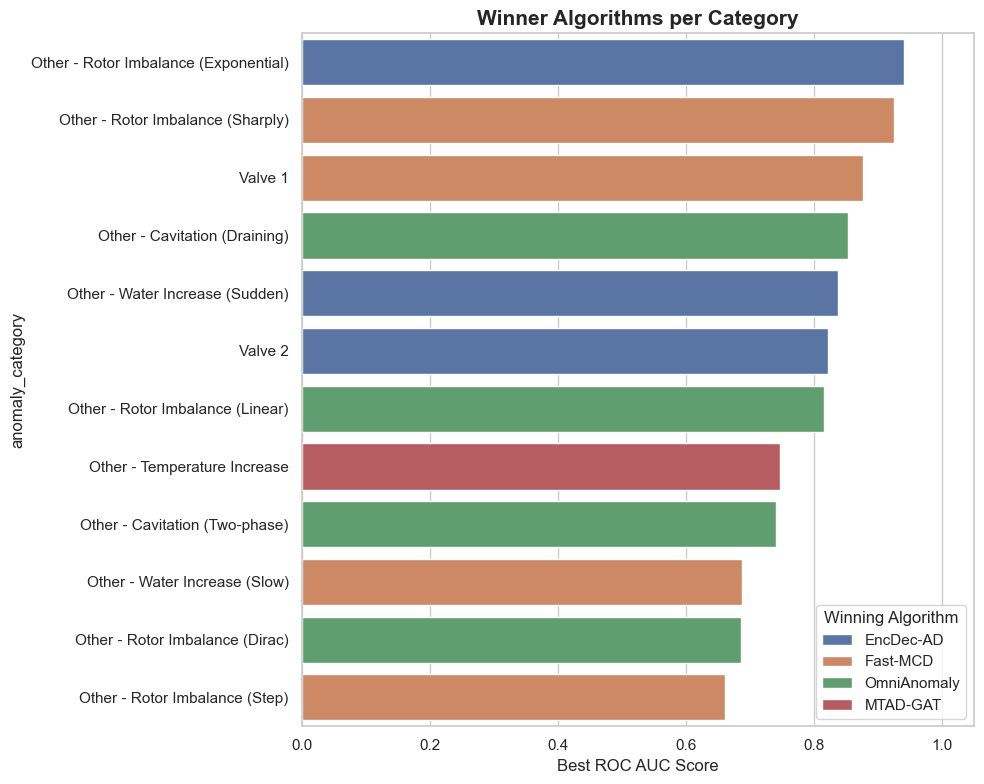


                          SUMMARY STATISTICS                          

Overall Algorithm Ranking (mean ROC_AUC):
  1. Fast-MCD                       0.7830
  2. OmniAnomaly                    0.7466
  3. EncDec-AD                      0.7409
  4. LSTM-AD                        0.7263
  5. Isolation Forest (iForest)     0.5631
  6. MTAD-GAT                       0.2623

Hardest Anomaly Categories (lowest scores):
  1. Other - Temperature Increase             0.4565
  2. Other - Rotor Imbalance (Step)           0.4976
  3. Other - Rotor Imbalance (Dirac)          0.5145
  4. Other - Cavitation (Two-phase)           0.5446
  5. Other - Cavitation (Draining)            0.5515



In [ ]:
# ============================================
# Analyze Results by Anomaly Category
# ============================================


# Get evaluation results
results_df = timeeval.get_results().reset_index()
print(f"Results columns: {results_df.columns.tolist()}")

# Load metadata directly from CSV file
meta_df = pd.read_csv("skabdata_v2/datasets.csv")
print(f"\nMetadata columns: {meta_df.columns.tolist()}")

# Merge results with anomaly category
full_df = pd.merge(
    results_df, 
    meta_df[['dataset_name', 'anomaly_category']], 
    left_on='dataset', 
    right_on='dataset_name', 
    how='left'
)

# Calculate average performance per category
category_perf = full_df.groupby(['anomaly_category', 'algorithm'])['ROC_AUC_mean'].mean().reset_index()

# Find best algorithm for each category
best_performers = category_perf.loc[category_perf.groupby('anomaly_category')['ROC_AUC_mean'].idxmax()]
best_performers = best_performers.sort_values(by='ROC_AUC_mean', ascending=False)

print("\n" + "="*70)
print("BEST ALGORITHM PER ANOMALY CATEGORY".center(70))
print("="*70)
print(best_performers[['anomaly_category', 'algorithm', 'ROC_AUC_mean']].to_string(index=False))

# Visualization 1: Heatmap
pivot_table = category_perf.pivot(index="anomaly_category", columns="algorithm", values="ROC_AUC_mean")

plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")

ax = sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".3f", 
    cmap="viridis", 
    linewidths=.5, 
    cbar_kws={'label': 'Mean ROC_AUC'}
)

plt.title('Algorithm Performance by Anomaly Category (SKAB)', fontsize=15, fontweight='bold')
plt.ylabel('Anomaly Category', fontsize=12)
plt.xlabel('Algorithm', fontsize=12)
plt.tight_layout()
plt.show()

# Visualization 2: Winner algorithms
plt.figure(figsize=(10, 8))
sns.barplot(
    data=best_performers, 
    x='ROC_AUC_mean', 
    y='anomaly_category', 
    hue='algorithm', 
    dodge=False, 
    palette='deep'
)
plt.title('Winner Algorithms per Category', fontsize=15, fontweight='bold')
plt.xlabel('Best ROC AUC Score')
plt.xlim(0, 1.05)
plt.legend(title='Winning Algorithm', loc='lower right')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS".center(70))
print("="*70)

# Overall algorithm ranking
overall_ranking = full_df.groupby('algorithm')['ROC_AUC_mean'].mean().sort_values(ascending=False)
print("\nOverall Algorithm Ranking (mean ROC_AUC):")
for i, (algo, score) in enumerate(overall_ranking.items(), 1):
    print(f"  {i}. {algo:<30} {score:.4f}")

# Hardest anomaly categories (lowest mean score)
category_difficulty = full_df.groupby('anomaly_category')['ROC_AUC_mean'].mean().sort_values()
print("\nHardest Anomaly Categories (lowest scores):")
for i, (cat, score) in enumerate(category_difficulty.head(5).items(), 1):
    print(f"  {i}. {cat:<40} {score:.4f}")

print("\n" + "="*70)
